In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.markers import MarkerStyle

In [2]:
df = pd.read_csv('/content/hvac_data.csv')

In [3]:
df.head()

,timestamps,location,equipment,temperature,used_power,humidity
0,2022-01-01 00:00:00+09:00,france,air_conditioning,16.85,585.4,94.89
1,2022-01-01 01:00:00+09:00,france,air_conditioning,15.80,8003.6,94.76
2,2022-01-01 02:00:00+09:00,france,air_conditioning,15.42,1033.6,94.96
3,2022-01-01 03:00:00+09:00,france,air_conditioning,17.01,1085.7,94.81
4,2022-01-01 04:00:00+09:00,france,air_conditioning,16.17,3551.7,94.13


In [4]:
df.isna().sum()

,0
timestamps,0
location,0
equipment,0
temperature,0
used_power,0
humidity,0


In [5]:
# Handle missing values
df.dropna(inplace=True)

# Convert timestamp data to datetime format
df['timestamps'] = pd.to_datetime(df['timestamps'])

# Extract year, month, day, hour, minute, second
df['year'] = df['timestamps'].dt.year
df['month'] = df['timestamps'].dt.month
df['day'] = df['timestamps'].dt.day
df['hour'] = df['timestamps'].dt.hour

In [6]:
df.head()

,timestamps,location,equipment,temperature,used_power,humidity,year,month,day,hour
0,2022-01-01 00:00:00+09:00,france,air_conditioning,16.85,585.4,94.89,2022,1,1,0
1,2022-01-01 01:00:00+09:00,france,air_conditioning,15.80,8003.6,94.76,2022,1,1,1
2,2022-01-01 02:00:00+09:00,france,air_conditioning,15.42,1033.6,94.96,2022,1,1,2
3,2022-01-01 03:00:00+09:00,france,air_conditioning,17.01,1085.7,94.81,2022,1,1,3
4,2022-01-01 04:00:00+09:00,france,air_conditioning,16.17,3551.7,94.13,2022,1,1,4


<ipython-input-7-483b73dd542c>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['continuous_hour'] = (df_filtered['day'] - 1) * 24 + df_filtered['hour'] + 1


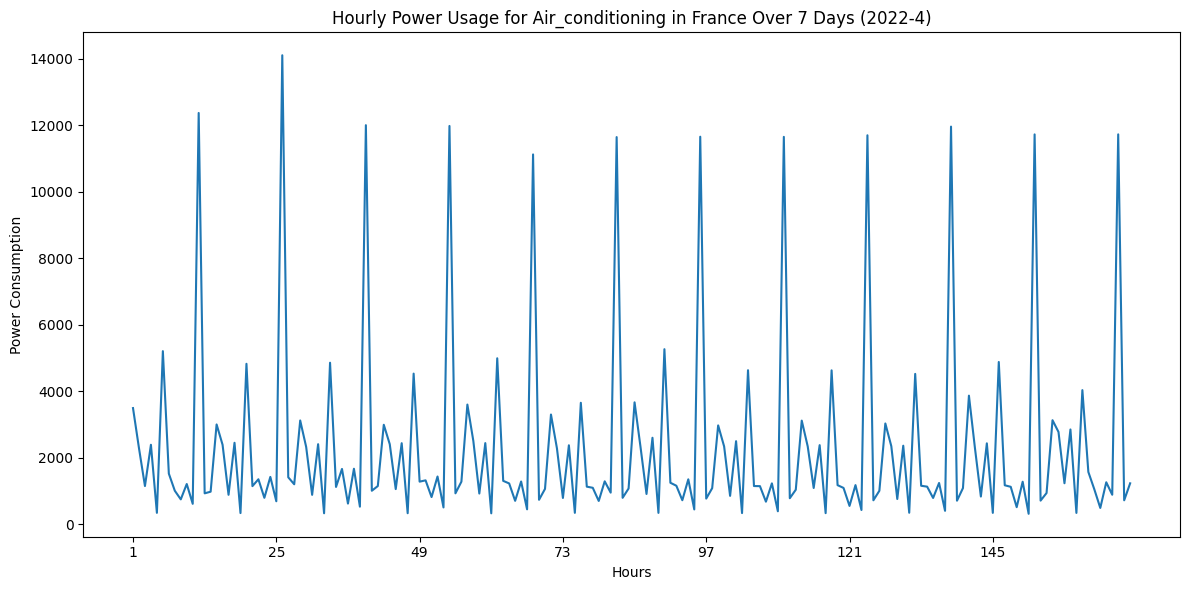

In [7]:
# Filter data for the required year, month, equipment, location, and first 7 days
year = 2022  # desired year
month = 4  # desired month
equipment = 'air_conditioning'  # desired equipment
location = 'france'  # desired location

# Filter data for the first 7 days of the month
df_filtered = df[(df['year'] == year) &
                 (df['month'] == month) &
                 (df['equipment'] == equipment) &
                 (df['location'] == location) &
                 (df['day'] <= 7)]

# Check if filtered data is not empty
if df_filtered.empty:
    print(f"No data found for {equipment} in {location} during {year}-{month} for the first 7 days.")
else:
    # Create a new column for continuous hour across 7 days
    df_filtered['continuous_hour'] = (df_filtered['day'] - 1) * 24 + df_filtered['hour'] + 1

    # Aggregate the data by continuous hour
    hourly_data = df_filtered.groupby('continuous_hour')['used_power'].sum()

    # Plot the hourly power usage over the continuous hours (1 to 168)
    plt.figure(figsize=(12, 6))
    plt.plot(hourly_data.index, hourly_data.values)
    plt.title(f'Hourly Power Usage for {equipment.capitalize()} in {location.capitalize()} Over 7 Days ({year}-{month})')
    plt.xlabel('Hours')
    plt.ylabel('Power Consumption')
    plt.xticks(ticks=range(1, 169, 24), labels=[f'{i}' for i in range(1, 169, 24)])  # Label every 24th hour
    plt.tight_layout()
    plt.show()

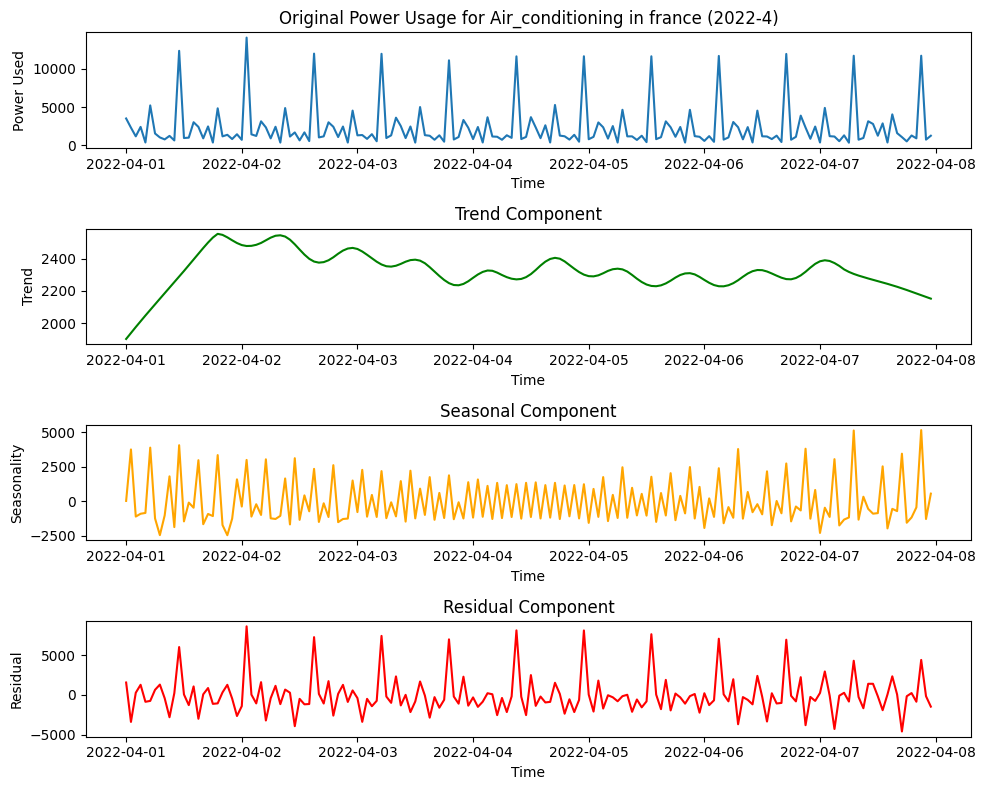

In [8]:
from statsmodels.tsa.seasonal import STL

# Ensure there is enough data for decomposition
if df_filtered.empty:
    print(f"No data found for {equipment} in {location} during {year}-{month}.")
else:
    # Check if the 'timestamps' column exists before setting it as the index
    if 'timestamps' in df_filtered.columns:
        # Aggregate the data by hourly usage
        df_filtered.set_index('timestamps', inplace=True)
        hourly_data = df_filtered['used_power'].resample('H').sum()

        # Apply STL decomposition with an odd seasonal period
        stl = STL(hourly_data, seasonal=23)  # Assuming seasonality repeats every 24 hours, using 23
        result = stl.fit()

        # Extract components
        trend = result.trend
        seasonal = result.seasonal
        residual = result.resid

        # Plot the components
        plt.figure(figsize=(10, 8))

        # Original Data
        plt.subplot(4, 1, 1)
        plt.plot(hourly_data, label='Original Data')
        plt.title(f'Original Power Usage for {equipment.capitalize()} in {location} ({year}-{month})')
        plt.xlabel('Time')
        plt.ylabel('Power Used')

        # Trend Component
        plt.subplot(4, 1, 2)
        plt.plot(trend, label='Trend', color='green')
        plt.title('Trend Component')
        plt.xlabel('Time')
        plt.ylabel('Trend')

        # Seasonal Component
        plt.subplot(4, 1, 3)
        plt.plot(seasonal, label='Seasonal', color='orange')
        plt.title('Seasonal Component')
        plt.xlabel('Time')
        plt.ylabel('Seasonality')

        # Residual Component
        plt.subplot(4, 1, 4)
        plt.plot(residual, label='Residual', color='red')
        plt.title('Residual Component')
        plt.xlabel('Time')
        plt.ylabel('Residual')

        plt.tight_layout()
        plt.show()
    else:
        print("Column 'timestamps' is missing in the dataset. Please check the data.")

In [9]:
!pip install pmdarima statsmodels

In [10]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")  # Ignore harmless warnings

# Assuming `hourly_data` contains your time series data for power consumption
# We use deseasonalized data for ARIMA to avoid issues with seasonality
deseasonalized_data = hourly_data - seasonal

# Parameter analysis with Auto ARIMA
stepwise_fit = auto_arima(deseasonalized_data,
                          start_p=1, start_q=1,
                          max_p=5, max_q=5,
                          m=24,  # For daily seasonality, m = 24 (24 hours in a day)
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',  # Ignore if certain models don't work
                          suppress_warnings=True,
                          stepwise=True)

# Display the best model parameters
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=15.28 sec
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=2815.092, Time=0.13 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=2733.079, Time=11.39 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=16.69 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=2813.122, Time=0.17 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=2812.572, Time=0.24 sec
 ARIMA(1,0,0)(2,1,0)[24] intercept   : AIC=2724.127, Time=15.61 sec
 ARIMA(1,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=27.79 sec
 ARIMA(1,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=4.84 sec
 ARIMA(0,0,0)(2,1,0)[24] intercept   : AIC=2722.158, Time=8.79 sec
 ARIMA(0,0,0)(1,1,0)[24] intercept   : AIC=2731.180, Time=1.22 sec
 ARIMA(0,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=16.26 sec
 ARIMA(0,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=3.93 sec
 ARIMA(0,0,1)(2,1,0)[24] intercept   : AIC=2724.307, Time=9.05 sec
 ARIMA(1,0,1)(2,1,0)[24] intercept   : AIC=

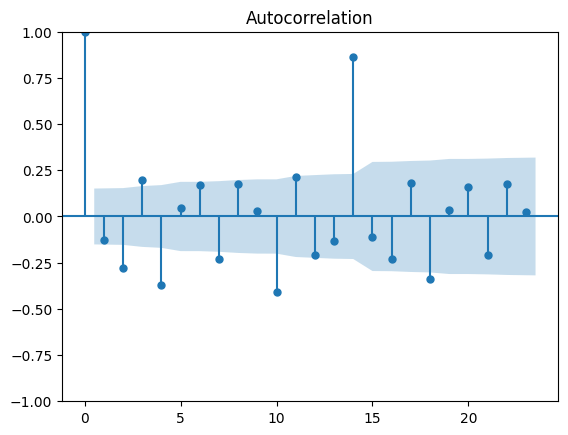

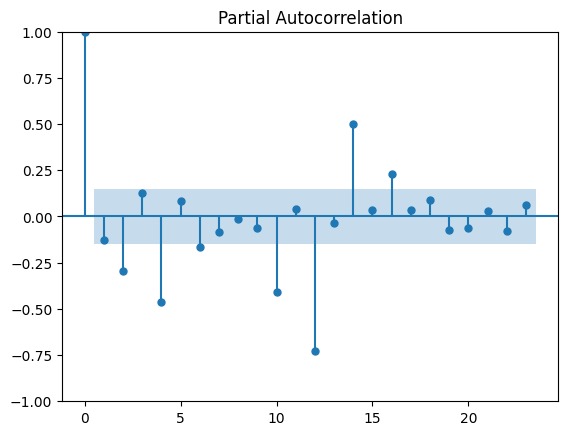

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF to determine p and q
plot_acf(deseasonalized_data)
plot_pacf(deseasonalized_data)
plt.show()

In [12]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(deseasonalized_data)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}') #if p<0.05 the data is stationary

ADF Statistic: -3.795341203575008
p-value: 0.0029553418582873928


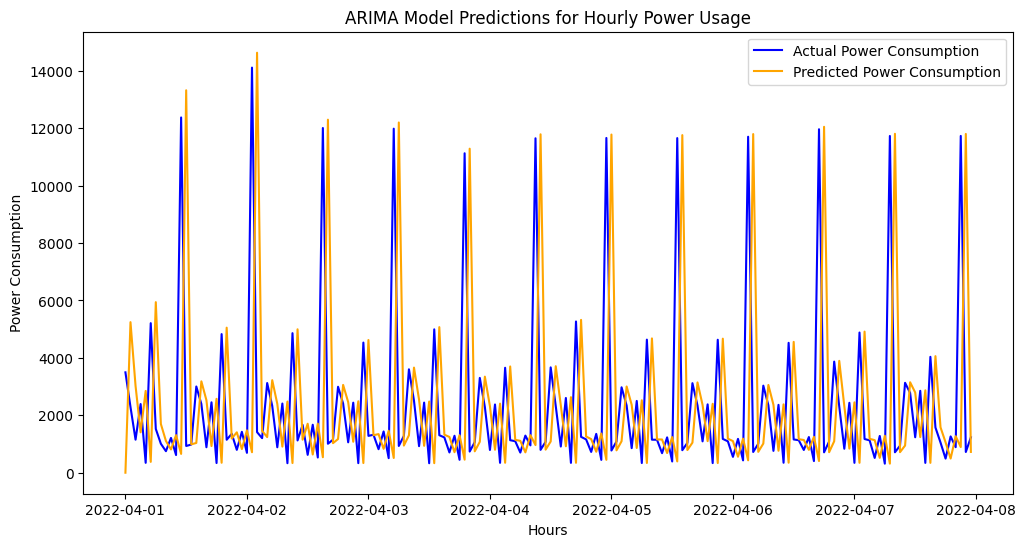

In [13]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define your p, d, q values for ARIMA
p = 0  # autoregressive term
d = 2  # differencing term
q = 1  # moving average term

# Step 2: Fit ARIMA model
model = ARIMA(hourly_data, order=(p, d, q))
result = model.fit()

# Step 3: Predict values for the entire dataset (including future time points)
start = 0  # Predict from the beginning of the data
end = len(hourly_data) - 1  # Predict until the end of the dataset

# Get predictions
predictions = result.predict(start=start, end=end)


# Step 4: Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(hourly_data.index, hourly_data.values, label='Actual Power Consumption', color='blue')
plt.plot(hourly_data.index, predictions, label='Predicted Power Consumption', color='orange', linestyle='-')
plt.title(f'ARIMA Model Predictions for Hourly Power Usage')
plt.xlabel('Hours')
plt.ylabel('Power Consumption')
plt.legend()
plt.show()


In [14]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(hourly_data, predictions)
rmse = np.sqrt(mse)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MSE: 22143783.84745291
RMSE: 4705.7182073996855


In [15]:
from pmdarima import auto_arima

# Use Auto ARIMA to automatically select the best (p, d, q) values
stepwise_fit = auto_arima(hourly_data, start_p=1, start_q=1, max_p=5, max_q=5, seasonal=False, trace=True)
print(stepwise_fit.summary())


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3244.162, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3236.830, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3240.243, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3224.385, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=3212.071, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=3203.756, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=3203.392, Time=0.07 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.98 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.87 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=3136.650, Time=0.55 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=3145.513, Time=1.43 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=6.55 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=3146.892, Time=0.82 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0] intercept
Total 

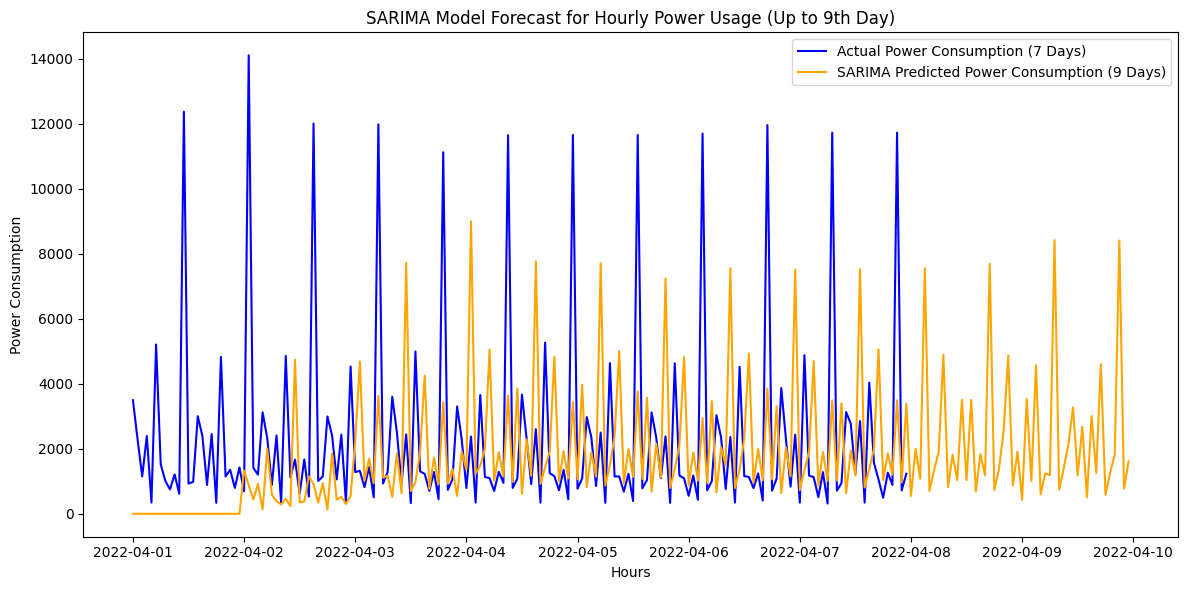

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define values for the seasonal component (P, D, Q, m)
P = 2  # Seasonal autoregressive term (can try 0, 1, or 2)
D = 1  # Seasonal differencing term (1 if there is seasonality, 0 otherwise)
Q = 0  # Seasonal moving average term (can try 0, 1, or 2)
m = 24  # Seasonal period (for hourly data, m=24 for daily seasonality)

# Define values for non-seasonal ARIMA component (p, d, q)
p = 0  # Autoregressive term
d = 0  # Differencing term
q = 0  # Moving average term

# Fit SARIMA model with seasonal components
model = SARIMAX(hourly_data, order=(p, d, q), seasonal_order=(P, D, Q, m))
result = model.fit()

# Predict with SARIMA
start_forecast = 168  # Start forecasting from the 168th hour
end_forecast = 216 - 1  # Forecast until the 240th hour (up to the 10th day)

predictions = result.predict(start=0, end=end_forecast)

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
forecast_index = pd.date_range(start=hourly_data.index[0], periods=216, freq='H')

# Plot actual data and forecasted values
plt.plot(hourly_data.index, hourly_data.values, label='Actual Power Consumption (7 Days)', color='blue')
plt.plot(forecast_index, predictions, label='SARIMA Predicted Power Consumption (9 Days)', color='orange', linestyle='-')

plt.title('SARIMA Model Forecast for Hourly Power Usage (Up to 9th Day)')
plt.xlabel('Hours')
plt.ylabel('Power Consumption')
plt.legend()
plt.tight_layout()
plt.show()


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[24] intercept   : AIC=inf, Time=21.84 sec
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=2817.321, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=2748.250, Time=2.08 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=3.85 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=2815.350, Time=0.14 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=2814.768, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[24] intercept   : AIC=2746.475, Time=8.82 sec
 ARIMA(1,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=15.32 sec
 ARIMA(1,0,0)(1,1,1)[24] intercept   : AIC=2740.973, Time=6.54 sec
 ARIMA(1,0,0)(0,1,1)[24] intercept   : AIC=inf, Time=5.65 sec
 ARIMA(1,0,0)(1,1,2)[24] intercept   : AIC=inf, Time=15.76 sec
 ARIMA(1,0,0)(0,1,2)[24] intercept   : AIC=inf, Time=13.74 sec
 ARIMA(1,0,0)(2,1,2)[24] intercept   : AIC=inf, Time=20.87 sec
 ARIMA(0,0,0)(1,1,1)[24] intercept   : AIC=2739.874, Time=9.71 sec
 ARIMA(0,0,0)(0,1,1)[24] intercept   : AIC=inf, T

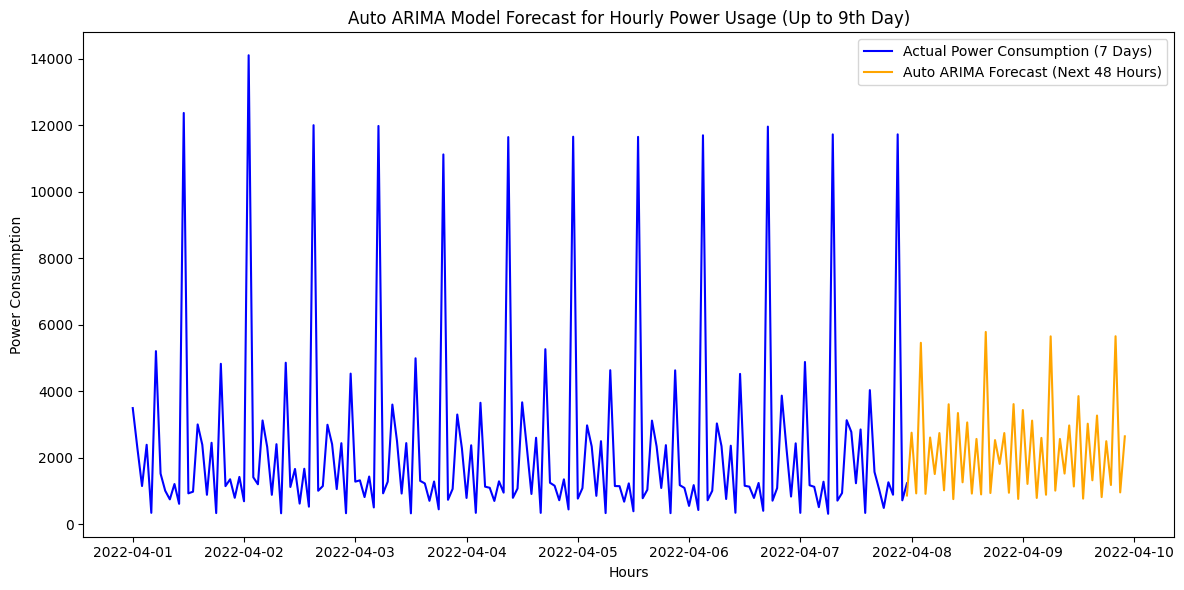

In [17]:
from pmdarima import auto_arima
import matplotlib.pyplot as plt

# Auto ARIMA to automatically find the best parameters (p, d, q) and (P, D, Q, m)
stepwise_fit = auto_arima(hourly_data,
                          start_p=1, start_q=1,  # Initial guess for p and q
                          max_p=5, max_q=5,      # Maximum values for p and q
                          m=24,                  # Seasonality (24 hours for daily pattern)
                          seasonal=True,         # Set to True for seasonal ARIMA
                          d=None,                # Let auto_arima determine the value of d
                          D=1,                   # Seasonal differencing (can also try with D=None for auto)
                          trace=True,            # Print results
                          error_action='ignore', # Ignore if a model doesn't work
                          suppress_warnings=True,
                          stepwise=True)         # Stepwise approach to select the best model

# Print the best model parameters
print(stepwise_fit.summary())

# Fit the model
best_model = stepwise_fit

# Step 3: Predict with the selected model
end_forecast = 216 - 1  # Forecast until the 240th hour
predictions = best_model.predict(n_periods=48)  # Forecast next 48 hours (up to 9th day)

# Plot the results
plt.figure(figsize=(12, 6))
forecast_index = pd.date_range(start=hourly_data.index[-1], periods=48, freq='H')  # Future time index
plt.plot(hourly_data.index, hourly_data.values, label='Actual Power Consumption (7 Days)', color='blue')
plt.plot(forecast_index, predictions, label='Auto ARIMA Forecast (Next 48 Hours)', color='orange', linestyle='-')

plt.title('Auto ARIMA Model Forecast for Hourly Power Usage (Up to 9th Day)')
plt.xlabel('Hours')
plt.ylabel('Power Consumption')
plt.legend()
plt.tight_layout()
plt.show()

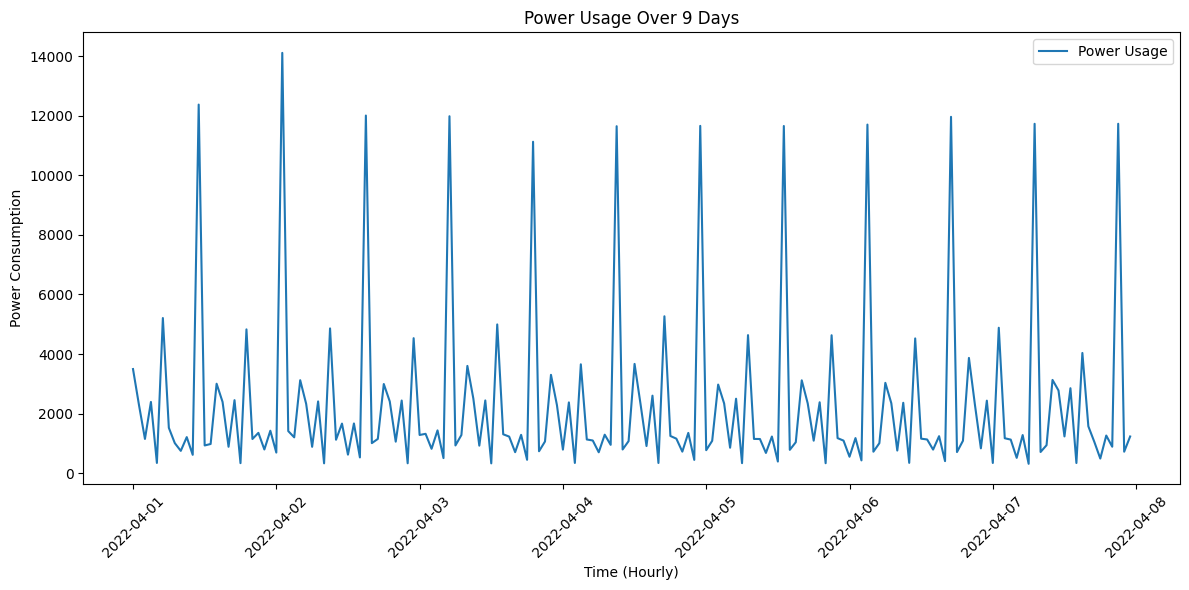

In [18]:
# Plot the data for the first 9 days
plt.figure(figsize=(12, 6))

# Create a time range for the 9 days (216 hours)
num_hours = 9 * 24
if len(hourly_data) < num_hours:
    num_hours = len(hourly_data)  # If the dataset has fewer than 216 hours

# Plot the first 9 days of data (or fewer if the data length is smaller)
plt.plot(hourly_data.index[:num_hours], hourly_data.values[:num_hours], label='Power Usage')

# Formatting the plot
plt.title('Power Usage Over 9 Days')
plt.xlabel('Time (Hourly)')
plt.ylabel('Power Consumption')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

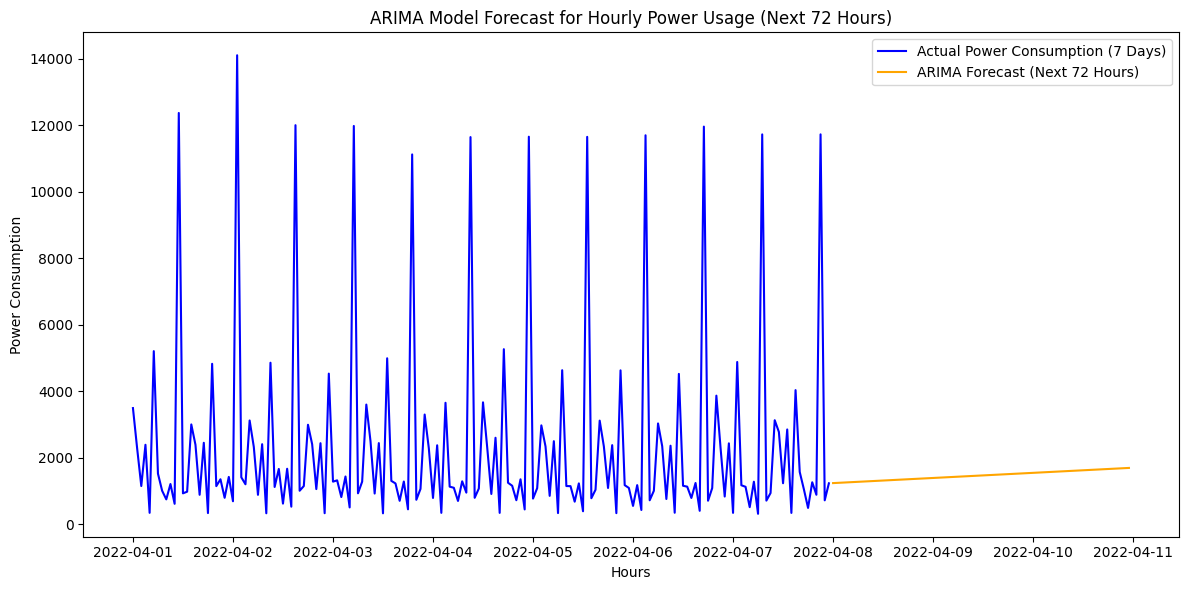

In [19]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Define your p, d, q values for ARIMA
p = 0  # Autoregressive term
d = 2  # Differencing term
q = 1  # Moving average term

# Step 2: Fit the ARIMA model on the data
model = ARIMA(hourly_data, order=(p, d, q))
result = model.fit()

# Step 3: Forecast the next 72 hours (3 days)
n_periods = 72  # Forecast the next 72 hours
forecast = result.predict(start=len(hourly_data), end=len(hourly_data) + n_periods - 1)

# Generate the forecast index for the next 72 hours
forecast_index = pd.date_range(start=hourly_data.index[-1], periods=n_periods + 1, freq='H')[1:]  # Shift 1 hour ahead

# Step 4: Plot the actual data and forecasted values
plt.figure(figsize=(12, 6))

# Plot the original data (actual values)
plt.plot(hourly_data.index, hourly_data.values, label='Actual Power Consumption (7 Days)', color='blue')

# Plot the forecasted values (future 72 hours)
plt.plot(forecast_index, forecast, label='ARIMA Forecast (Next 72 Hours)', color='orange', linestyle='-')

# Formatting the plot
plt.title('ARIMA Model Forecast for Hourly Power Usage (Next 72 Hours)')
plt.xlabel('Hours')
plt.ylabel('Power Consumption')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()
